In [35]:
from utils.misc import *
from train.train import Train,Test
from datasets.data_utils import load_dataset
from model.Creat_model import creat_model
from utils.preprocess import *
from utils.utils import *

In [2]:
from torch.backends import cudnn
def fix_seed(seed):
    #seed = 2023
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'   

In [3]:
import networkx
import torch
import scipy.sparse as sp
import numpy as np
import os
import random
from munkres import Munkres
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.decomposition import PCA
from torch.utils.data import Dataset
import argparse
import yaml
from torch_geometric.utils.convert import to_networkx
import pynvml

def build_args():
    
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--dataset', type=str, default="acm")
    parser.add_argument('--seed', type=int, default=20)
    parser.add_argument('--cuda', type=bool, default=True)
    parser.add_argument('--n_input', type=int, default=None)
    parser.add_argument('--n_z', type=int, default=None)
    parser.add_argument('--freedom_degree', type=float, default=1.0)
    parser.add_argument('--epoch', type=int, default=None)
    parser.add_argument('--shuffle', type=bool, default=True)
    parser.add_argument('--sigma', type=float, default=None)
    parser.add_argument('--loss_n', type=float, default=None)
    parser.add_argument('--loss_w', type=float, default=None)
    parser.add_argument('--loss_s', type=float, default=None)
    parser.add_argument('--loss_a', type=float, default=None)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--acc', type=float, default=-1)
    parser.add_argument('--f1', type=float, default=-1)
    args = parser.parse_args([])
    return args

In [4]:
def pca(adata, use_reps=None, n_comps=10):
    
    """Dimension reduction with PCA algorithm"""
    
    from sklearn.decomposition import PCA
    from scipy.sparse.csc import csc_matrix
    from scipy.sparse.csr import csr_matrix
    pca = PCA(n_components=n_comps)
    if use_reps is not None:
       feat_pca = pca.fit_transform(adata.obsm[use_reps])
    else: 
       if isinstance(adata.X, csc_matrix) or isinstance(adata.X, csr_matrix):
          feat_pca = pca.fit_transform(adata.X.toarray()) 
       else:   
          feat_pca = pca.fit_transform(adata.X)
    
    return feat_pca

def clr_normalize_each_cell(adata, inplace=True):
    
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()
    
    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else np.array(adata.X))
    )
    return adata     
def lsi(
        adata: anndata.AnnData, n_components: int = 20,
        use_highly_variable: Optional[bool] = None, **kwargs
       ) -> None:
    r"""
    LSI analysis (following the Seurat v3 approach)
    """
    if use_highly_variable is None:
        use_highly_variable = "highly_variable" in adata.var
    adata_use = adata[:, adata.var["highly_variable"]] if use_highly_variable else adata
    X = tfidf(adata_use.X)
    #X = adata_use.X
    X_norm = sklearn.preprocessing.Normalizer(norm="l1").fit_transform(X)
    X_norm = np.log1p(X_norm * 1e4)
    X_lsi = sklearn.utils.extmath.randomized_svd(X_norm, n_components, **kwargs)[0]
    X_lsi -= X_lsi.mean(axis=1, keepdims=True)
    X_lsi /= X_lsi.std(axis=1, ddof=1, keepdims=True)
    #adata.obsm["X_lsi"] = X_lsi
    adata.obsm["X_lsi"] = X_lsi[:,1:]   
def tfidf(X):
    r"""
    TF-IDF normalization (following the Seurat v3 approach)
    """
    idf = X.shape[0] / X.sum(axis=0)
    if scipy.sparse.issparse(X):
        tf = X.multiply(1 / X.sum(axis=1))
        return tf.multiply(idf)
    else:
        tf = X / X.sum(axis=1, keepdims=True)
        return tf * idf   


In [5]:
args = build_args()
args = load_configs(args, "config/configs.yml")
# set_random_seed(2024)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

load configs


In [6]:
import h5py
import numpy as np
import scanpy as sc
data_mat = h5py.File('/home/hfzhang/data/空间转录组/MISAR_seq_mouse_E15_brain_data/MISAR_seq_mouse_E15_brain_mRNA_data.h5', 'r')
df_data_RNA = np.array(data_mat['X']).astype('float64')     # gene count matrix
data_mat1 = h5py.File('/home/hfzhang/data/空间转录组/MISAR_seq_mouse_E15_brain_data/MISAR_seq_mouse_E15_brain_ATAC_data.h5', 'r')
df_data_protein = np.array(data_mat1['X']).astype('float64')  # protein count matrix
loc = np.array(data_mat['pos']).astype('float64') 
gene_names = list(data_mat['gene'])
ATAC_names = list(data_mat1['peak'])
gene_names = [gene.decode("utf-8") for gene in gene_names]
ATAC_names = [peak.decode("utf-8") for peak in ATAC_names]
LayerName = list(data_mat['Y'])
LayerName = [item.decode("utf-8") for item in LayerName]
# protein_names = list(data_mat['peak'])
# protein_names = [protein.decode("utf-8") for protein in protein_names]
# protein_names = [protein.split(".")[0] for protein in protein_names]
adata1 = sc.AnnData(df_data_RNA, dtype="float64")
adata1.var.index = gene_names
sc.pp.normalize_per_cell(adata1)
sc.pp.log1p(adata1)

adata2 = sc.AnnData(df_data_protein, dtype="float64")
adata2.var.index = ATAC_names
# sc.pp.log1p(adata2)

adata1.obs['LayerName']=LayerName
adata2.obs['LayerName']=LayerName
adata1.obsm['spatial'] = np.array(loc)
adata1.obs['x_pos'] = np.array(loc)[:,0]
adata1.obs['y_pos'] = np.array(loc)[:,1]


adata2.obsm['spatial'] = np.array(loc)
adata2.obs['x_pos'] = np.array(loc)[:,0]
adata2.obs['y_pos'] = np.array(loc)[:,1]



In [7]:
adata2.X

array([[4., 4., 4., ..., 1., 0., 2.],
       [4., 4., 4., ..., 2., 0., 0.],
       [4., 4., 4., ..., 0., 0., 0.],
       ...,
       [0., 0., 2., ..., 0., 0., 0.],
       [1., 2., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
adata_omics1=adata1
adata_omics2=adata2

In [40]:

# RNA
# sc.pp.filter_genes(adata_omics1, min_cells=10)
# sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
# sc.pp.normalize_total(adata_omics1, target_sum=1e4)
# sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)

# adata_omics1 =  adata_omics1[:, adata_omics1.var['highly_variable']]
# adata_omics1.obsm['feat'] = pca(adata_omics1, n_comps=100)
# Protein
# adata_omics2 = clr_normalize_each_cell(adata_omics2)
# sc.pp.scale(adata_omics2)
# adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=adata_omics2.n_vars-1)

# ATAC
sc.pp.highly_variable_genes(adata_omics2, flavor="seurat_v3", n_top_genes=3000)
adata_omics2 =  adata_omics2[:, adata_omics2.var['highly_variable']]
lsi(adata_omics2, use_highly_variable=False, n_components=200 + 1)
adata_omics2.obsm['feat'] = adata_omics2.obsm['X_lsi'].copy()

In [25]:
adata_omics1

AnnData object with n_obs × n_vars = 1949 × 2144
    obs: 'n_counts', 'LayerName', 'x_pos', 'y_pos'
    var: 'mean', 'std'
    uns: 'log1p', 'adj_spatial'
    obsm: 'spatial'

In [26]:
def create_adj(adata):
    cell_position_omics1 = adata.obsm['spatial']
    adj_omics1 = construct_graph_by_coordinate(cell_position_omics1, n_neighbors=3)
    adata.uns['adj_spatial'] = adj_omics1
    adj_spatial_omics1 = adata.uns['adj_spatial']
    adj_spatial_omics1 = transform_adjacent_matrix(adj_spatial_omics1)
    adj_spatial_omics1 = adj_spatial_omics1.toarray()
    adj_spatial_omics1 = adj_spatial_omics1 + adj_spatial_omics1.T
    adj_spatial_omics1 = np.where(adj_spatial_omics1>1, 1, adj_spatial_omics1)
    adj = preprocess_graph(adj_spatial_omics1)
    return adj

In [27]:
label=adata_omics2.obs['LayerName'].values
classes, label = np.unique(label, return_inverse=True)
classes = classes.tolist()

In [28]:
args.n_input=adata_omics1.n_vars
args.n_input1=200
args.n_clusters=len(classes)
args.n_clusters
random_seek=2020
args.random_seed=random_seek
fix_seed(random_seek)

In [67]:
args.loss_a=0.1
args.loss_n=0.1
args.lr=0.01
device='cuda:0'
args.sigma=0.5

In [69]:
args.n_clusters1=len(set(label))
args.n_clusters2=len(set(label))
adj_train=create_adj(adata_omics1)
adj_train = adj_train.to(device)
features_omics1 = torch.FloatTensor(adata_omics1.X.copy()).to(device)
features_omics2 = torch.FloatTensor(adata_omics2.obsm['feat'].copy()).to(device)
model = creat_model('spamgcn', args).to(device)
model=Train(400, model, features_omics1,features_omics2, adj_train, label, device, args)
nmi, ari, ami, homogeneity, completeness, v_measure=Test(model,adata_omics1,features_omics1,features_omics2,adj_train,label,device,args,'leiden')


  9 loss: 2.2927565574645996
Epoch_  9 , nmi 0.3270 , ari 0.1862 , ami 0.3234 , homogeneity 0.3442 , completeness 0.3114 , v_measure 0.3270
 19 loss: 2.0635416507720947
Epoch_ 19 , nmi 0.2787 , ari 0.1746 , ami 0.2748 , homogeneity 0.2854 , completeness 0.2723 , v_measure 0.2787
 29 loss: 2.011291980743408
Epoch_ 29 , nmi 0.3033 , ari 0.1745 , ami 0.2996 , homogeneity 0.3180 , completeness 0.2900 , v_measure 0.3033
 39 loss: 1.9863423109054565
Epoch_ 39 , nmi 0.3173 , ari 0.1677 , ami 0.3135 , homogeneity 0.3210 , completeness 0.3137 , v_measure 0.3173
 49 loss: 2.6485073566436768
Epoch_ 49 , nmi 0.4290 , ari 0.2699 , ami 0.4258 , homogeneity 0.4358 , completeness 0.4224 , v_measure 0.4290
 59 loss: 2.624281167984009
Epoch_ 59 , nmi 0.4395 , ari 0.2883 , ami 0.4363 , homogeneity 0.4315 , completeness 0.4479 , v_measure 0.4395
 69 loss: 2.5986759662628174
Epoch_ 69 , nmi 0.4471 , ari 0.2640 , ami 0.4440 , homogeneity 0.4483 , completeness 0.4460 , v_measure 0.4471
 79 loss: 2.6056106090

/home/hfzhang/software/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


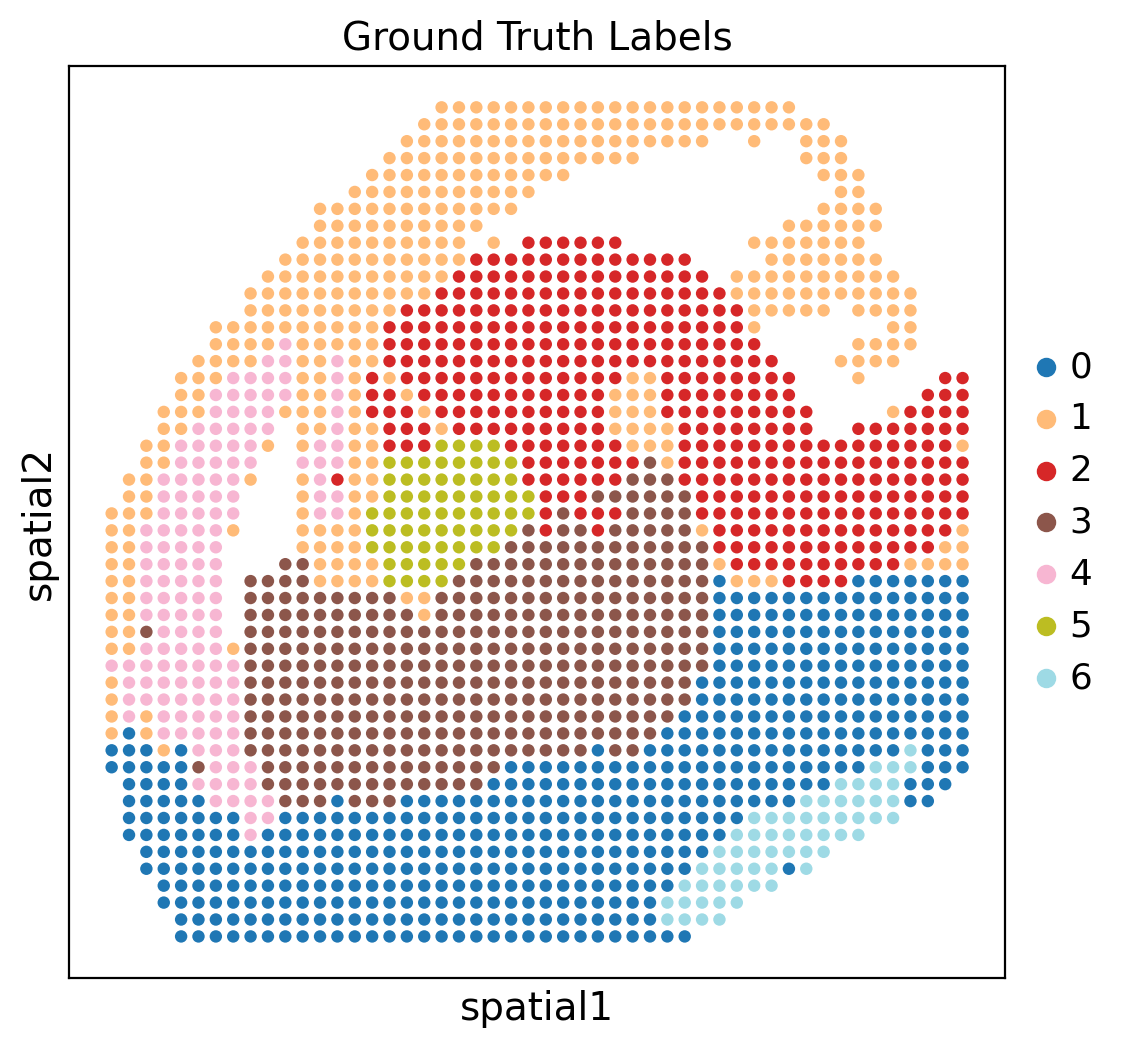

In [11]:
import scanpy as sc
import matplotlib.pyplot as plt


# 2. 设置绘图参数
sc.set_figure_params(figsize=(6, 6), dpi=100)

# 3. 绘制真实标签的嵌入图
sc.pl.embedding(
    adata_omics1,
    basis='spatial',  # 使用空间坐标
    color='pred',  # 使用 obs 中的 ground_truth 列作为颜色
    title='Ground Truth Labels',
    palette='tab20',  # 使用高对比度的颜色映射
    size=80,  # 调整点的大小，值越大，点越大
    show=False,  # 不立即显示，方便保存或调整
)


# 5. 显示图像
plt.show()

In [ ]:
Epoch_  0 : acc 0.5946 , nmi 0.6081 , ari 0.4572 , f1 0.5148 , homogeneity 0.5918 , completeness 0.6253 , v_measure 0.6081

In [ ]:
def eva(y_true, y_pred, epoch=0):  
    if torch.is_tensor(y_true):  
        y_true = y_true.cpu().numpy()  

    acc, f1 = cluster_acc(y_true, y_pred)  
    ami = adjusted_mutual_info_score(y_true, y_pred)  
    nmi = nmi_score(y_true, y_pred, average_method='arithmetic')  
    ari = ari_score(y_true, y_pred)  
    homogeneity = homogeneity_score(y_true, y_pred)  
    completeness = completeness_score(y_true, y_pred)  
    v_measure = v_measure_score(y_true, y_pred)  

    print('Epoch_{:3d}'.format(epoch),  
          ': acc {:.4f}'.format(acc),  
          ', nmi {:.4f}'.format(nmi),  
          ', ari {:.4f}'.format(ari),  
          ', ami {:.4f}'.format(ami),  
          ', homogeneity {:.4f}'.format(homogeneity),  
          ', completeness {:.4f}'.format(completeness),  
          ', v_measure {:.4f}'.format(v_measure))  

In [ ]:
a=sc.read_h5ad('/home/hfzhang/workplace/空间转录组/spaMGCN-main/MGCN-main/save/spaMGCN_S3_2022.h5ad')

In [ ]:
label=a.obs['final_annot'].values
classes, label = np.unique(label, return_inverse=True)
classes = classes.tolist()

In [ ]:
eva(label,a.obs['pred'])

Epoch_  0 : acc 0.5613 , nmi 0.5379 , ari 0.4064 , ami 0.5354 , homogeneity 0.5495 , completeness 0.5269 , v_measure 0.5379


In [ ]:
a.write_h5ad('/home/hfzhang/workplace/空间转录组/spaMGCN-main/MGCN-main/save/spaMGCN_S3_'+str(random_seek)+'.h5ad')

In [ ]:
Epoch_  0 : acc 0.5669 , nmi 0.4263 , ari 0.3254 , ami 0.4223 , homogeneity 0.4207 , completeness 0.4321 , v_measure 0.4263 300
Epoch_  0 : acc 0.5364 , nmi 0.4298 , ari 0.3165 , ami 0.4258 , homogeneity 0.4304 , completeness 0.4293 , v_measure 0.4298
Epoch_  0 : acc 0.5464 , nmi 0.4188 , ari 0.3085 , ami 0.4148 , homogeneity 0.4160 , completeness 0.4218 , v_measure 0.4188
ACC: 0.4513, NMI: 0.3998, ARI: 0.2490, AMI: 0.3958, Homogeneity: 0.4214, Completeness: 0.3803, V-measure: 0.3998
ACC: 0.5508, NMI: 0.4220, ARI: 0.3126, AMI: 0.4180, Homogeneity: 0.4161, Completeness: 0.4280, V-measure: 0.4220

In [ ]:
print(f"ACC: {acc:.4f}, NMI: {nmi:.4f}, ARI: {ari:.4f}, AMI: {ami:.4f}, Homogeneity: {homogeneity:.4f}, Completeness: {completeness:.4f}, V-measure: {v_measure:.4f}")

ACC: 0.5508, NMI: 0.4220, ARI: 0.3126, AMI: 0.4180, Homogeneity: 0.4161, Completeness: 0.4280, V-measure: 0.4220
